# Covid-19: From model prediction to model predictive control

## Scenario-analysis with the age-stratified deterministic model

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook was made to quickly perform scenario analysis with the age-stratified model implementation.

### Load required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import datetime
import scipy
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st
import networkx # to install networkx in your environment: conda install networkx
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import polymod
from covid19model.data import parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
import math

### Load interaction matrices

In [2]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = polymod.get_interaction_matrices()

### Load parameter values for age-stratified deterministic model and adjust for stochastic model

In [3]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = polymod.get_interaction_matrices()
params = parameters.get_COVID19_SEIRD_parameters()
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# some required parameters are different, the 'parameter loading function' must be changed in the future
params.update({'theta': 0,
               'beta':0.035,
               'Nc': Nc_total}) # add length of a discrete timestep to parameter dictionary (days)
del params['totalTests']
del params['dq']
del params['psi_FP']
del params['psi_PP']

### Initialise model

In [4]:
levels = initN.size
initial_states = {'S': initN, 'E': np.ones(levels)}

In [5]:
model = models.COVID19_SEIRD_sto(initial_states, params)

### Scrape high-level Sciensano data

In [6]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)

In [7]:
df_sciensano.head()

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum
DATE,,,,,
2020-03-15,266,54,71,18,53
2020-03-16,370,79,90,14,129
2020-03-17,497,100,123,31,221
2020-03-18,650,131,183,48,356
2020-03-19,844,165,212,49,519


### Example simulation

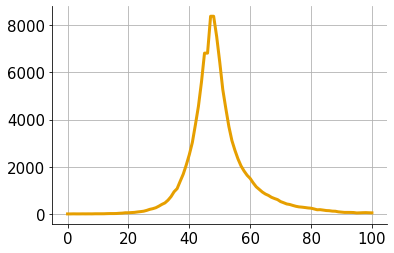

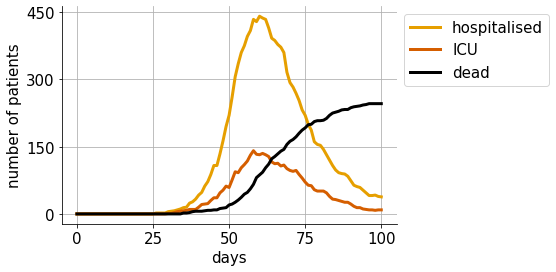

In [8]:
# Create checkpoints dictionary
chk = {'time':  [45], 
       'Nc':    [0.3*Nc_home]
      }
# Run a checkpointed simulation
out=model.sim(100,checkpoints=chk)
# Visualise the number of pre-symptomatic infections over all ages
plt.plot(out["time"],out["I"].sum(dim="stratification"))
# Built-in function to visualise the number of patients in hospitals, in ICU and deaths
infected(out)

### Performing a calibration

Use the function fit_pso to obtain a good first estimate for the MCMC sampler.

In [20]:
from covid19model.optimization import MCMC

# define dataset
data=[df_sciensano["H_in"].values[:7]]
# set optimisation settings
parNames = ['sigma_ICU','extraTime','beta'] # must be a list!
states = [["H_in"]]
bounds=((1,50),(20,80),(0.03,0.06)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,maxiter=30,popsize=100)

No constraints given.
New best for swarm at iteration 1: [26.03731114 36.9195827   0.05290143] 25.086083482830965
Best after iteration 1: [26.03731114 36.9195827   0.05290143] 25.086083482830965
Best after iteration 2: [26.03731114 36.9195827   0.05290143] 25.086083482830965
Best after iteration 3: [26.03731114 36.9195827   0.05290143] 25.086083482830965
New best for swarm at iteration 4: [21.09361554 36.5174342   0.04901539] 23.724009535465065
Best after iteration 4: [21.09361554 36.5174342   0.04901539] 23.724009535465065
Best after iteration 5: [21.09361554 36.5174342   0.04901539] 23.724009535465065
Best after iteration 6: [21.09361554 36.5174342   0.04901539] 23.724009535465065
New best for swarm at iteration 7: [16.0482693  37.30865805  0.04732083] 21.642395807556245
Best after iteration 7: [16.0482693  37.30865805  0.04732083] 21.642395807556245
Best after iteration 8: [16.0482693  37.30865805  0.04732083] 21.642395807556245
Best after iteration 9: [16.0482693  37.30865805  0.04

In [21]:
model.extraTime = int(round(theta[1]))
model.parameters.update({
    'beta': theta[2],
}
)

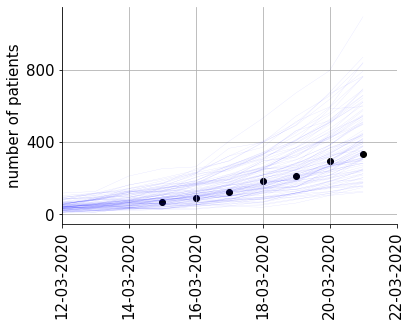

In [22]:
plot_fit(model,data,'15-03-2020',states)

Initiatize and run the sampler

In [32]:
model.extraTime = int(round(theta[1]))
theta = [theta[0],theta[2]]
print(model.extraTime,theta)

48 [19.998061481448463, 0.034616132046053266]


In [33]:
import emcee
from covid19model.optimization import objective_fcns

parNames = ['sigma_ICU','beta'] # must be a list!
states = [["ICU"]]
bounds=((1,100),(0.01,0.10))

pos = theta + [5, 1e-2 ]* np.random.randn(4, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames))
sampler.run_mcmc(pos, 300, progress=True);

100%|██████████| 300/300 [00:27<00:00, 10.94it/s]


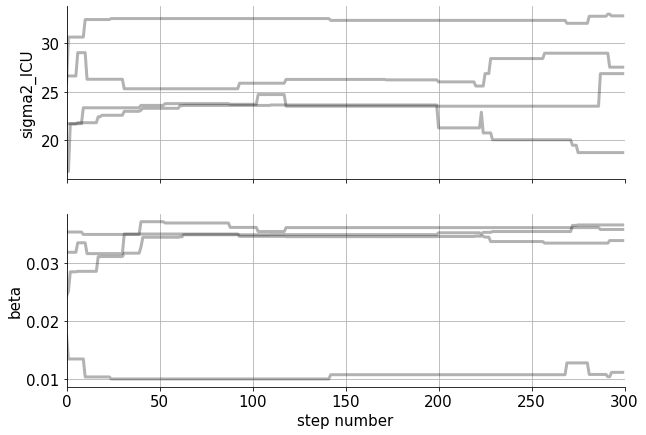

In [34]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["sigma2_ICU","beta"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [18]:
sampler.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 80;
tau: [180.56047754 197.29867267]

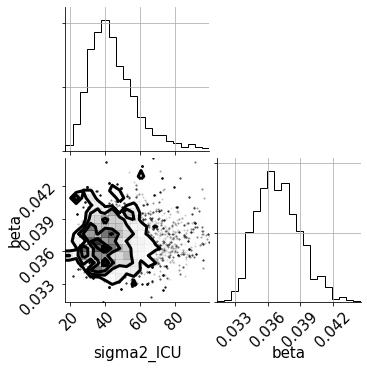

In [19]:
import corner

flat_samples = sampler.get_chain(discard=500, thin=1, flat=True)
fig = corner.corner(
    flat_samples, labels=labels,
);

To do: quick visualisation of the fit + samples. Can we make extraTime a non-integer variable?

# Notebook works till here

### Calibration of the hospitalization parameters

#### Calibrate $d_c$, $d_{icu}$ and $d_{icu, rec}$ to the new hospitalizations and hospital discharges

In [ ]:
sigma = 0.40
Nc = 0.2*Nc_home+sigma*((1-0.70)*Nc_work+(1-0.70)*Nc_transport)

# Create a dictionary of past policies
chk = {'t':       [model.extraTime], 
       'Nc':      [Nc]
      }

data=[np.transpose(H_in[:,0:50]),np.transpose(H_out[:,0:50]),np.transpose(ICU_tot[:,0:50]),np.transpose(H_tot_cumsum[:,0:50])]
# set optimisation settings
parNames = ['dc','dICU','dICUrec'] # must be a list!
positions = [np.array([14]),np.array([15]),np.array([6]),np.array([5,6])] # must be a list!
bounds=((5,13),(6,15),(1,14)) # must be a list!
weights = np.array([10,10,1,1])
# run optimisation
theta = model.fit(data,parNames,positions,bounds,weights,checkpoints=chk,setvar=True,maxiter=10,popsize=100)
# plot result
model.plotFit(index[0:50],data,positions,checkpoints=chk,modelClr=['red','orange','blue','black'],legendText=('H_in (model)','H_out (model)','ICU_tot (model)','H_tot (model)'),titleText='Belgium')

No constraints given.
Best after iteration 1: [ 5.3583188  10.70333175 13.77271807] 18112634.078569368
Best after iteration 2: [ 5.3583188  10.70333175 13.77271807] 18112634.078569368
New best for swarm at iteration 3: [ 5.06045676  9.62933638 13.18904514] 17294191.043551125
Best after iteration 3: [ 5.06045676  9.62933638 13.18904514] 17294191.043551125
New best for swarm at iteration 4: [ 5.16220853 10.07982114 10.1505103 ] 15693858.962078132
Best after iteration 4: [ 5.16220853 10.07982114 10.1505103 ] 15693858.962078132
Best after iteration 5: [ 5.16220853 10.07982114 10.1505103 ] 15693858.962078132
Best after iteration 6: [ 5.16220853 10.07982114 10.1505103 ] 15693858.962078132
Best after iteration 7: [ 5.16220853 10.07982114 10.1505103 ] 15693858.962078132
Best after iteration 8: [ 5.16220853 10.07982114 10.1505103 ] 15693858.962078132


In [ ]:
# Length of dataset
n=theano.shared(float(ICU_tot[:,0:30].size))

# Define coupling function of pyMC3-ICU 
@as_op(itypes=[tt.dscalar,tt.dscalar,tt.dscalar,tt.dscalar], otypes=[tt.dvector])
def coupleICU_tot2COVID19MODEL(dc,dICU,dICUrec,n):
    model.dc = dc
    model.dICU = dICU
    model.dICUrec = dICUrec
    T = n+model.extraTime-1
    model.sim(T,checkpoints=chk)
    mdl_out = (model.sumS,model.sumE,model.sumI,model.sumA,model.sumM,model.sumCtot,model.sumICU,model.sumR,model.sumD,model.sumSQ,model.sumEQ,model.sumAQ,model.sumMQ,model.sumRQ,model.sumH_in,model.sumH_out)
    positions = np.array([6])
    som = 0
    for idx in positions:
        som = som + np.mean(mdl_out[idx],axis=1).reshape(np.mean(mdl_out[idx],axis=1).size,1)
    return som[int(model.extraTime):].flatten()

# Define coupling function of pyMC3-Hospital 
@as_op(itypes=[tt.dscalar,tt.dscalar,tt.dscalar,tt.dscalar], otypes=[tt.dvector])
def coupleH_tot2COVID19MODEL(dc,dICU,dICUrec,n):
    model.dc = dc
    model.dICU = dICU
    model.dICUrec = dICUrec
    T = n+model.extraTime-1
    model.sim(T,checkpoints=chk)
    mdl_out = (model.sumS,model.sumE,model.sumI,model.sumA,model.sumM,model.sumCtot,model.sumICU,model.sumR,model.sumD,model.sumSQ,model.sumEQ,model.sumAQ,model.sumMQ,model.sumRQ,model.sumH_in,model.sumH_out)
    positions = np.array([5,6])
    som = 0
    for idx in positions:
        som = som + np.mean(mdl_out[idx],axis=1).reshape(np.mean(mdl_out[idx],axis=1).size,1)
    return som[int(model.extraTime):].flatten()

# Define coupling function of pyMC3-Hospital 
@as_op(itypes=[tt.dscalar,tt.dscalar,tt.dscalar,tt.dscalar], otypes=[tt.dvector])
def coupleH_in2COVID19MODEL(dc,dICU,dICUrec,n):
    model.dc = dc
    model.dICU = dICU
    model.dICUrec = dICUrec
    T = n+model.extraTime-1
    model.sim(T,checkpoints=chk)
    mdl_out = (model.sumS,model.sumE,model.sumI,model.sumA,model.sumM,model.sumCtot,model.sumICU,model.sumR,model.sumD,model.sumSQ,model.sumEQ,model.sumAQ,model.sumMQ,model.sumRQ,model.sumH_in,model.sumH_out)
    positions = np.array([14])
    som = 0
    for idx in positions:
        som = som + np.mean(mdl_out[idx],axis=1).reshape(np.mean(mdl_out[idx],axis=1).size,1)
    return som[int(model.extraTime):].flatten()

# Define coupling function of pyMC3-Hospital 
@as_op(itypes=[tt.dscalar,tt.dscalar,tt.dscalar,tt.dscalar], otypes=[tt.dvector])
def coupleH_out2COVID19MODEL(dc,dICU,dICUrec,n):
    model.dc = dc
    model.dICU = dICU
    model.dICUrec = dICUrec
    T = n+model.extraTime-1
    model.sim(T,checkpoints=chk)
    mdl_out = (model.sumS,model.sumE,model.sumI,model.sumA,model.sumM,model.sumCtot,model.sumICU,model.sumR,model.sumD,model.sumSQ,model.sumEQ,model.sumAQ,model.sumMQ,model.sumRQ,model.sumH_in,model.sumH_out)
    positions = np.array([15])
    som = 0
    for idx in positions:
        som = som + np.mean(mdl_out[idx],axis=1).reshape(np.mean(mdl_out[idx],axis=1).size,1)
    return som[int(model.extraTime):].flatten()

# Define prior distributions of parameters
with pm.Model() as COVID19MODEL:
    db = pm.backends.Text('test')
    BoundedNormal = pm.Bound(pm.Normal, lower=1.0)
    # Priors for unknown model parameters
    dc = BoundedNormal('dc', mu=model.dc, sigma=1)
    dICU = BoundedNormal('dICU', mu=model.dICU, sigma=1)
    dICUrec = BoundedNormal('dICUrec', mu=model.dICUrec, sigma=1)
    sigma_ICU_tot = pm.HalfNormal('sigma_ICU_tot', sigma=10)
    sigma_H_tot = pm.HalfNormal('sigma_H_tot', sigma=10)
    sigma_H_in = pm.HalfNormal('sigma_H_in', sigma=10)
    sigma_H_out = pm.HalfNormal('sigma_H_out', sigma=10)

    mu_ICU_tot = coupleICU_tot2COVID19MODEL(dc,dICU,dICUrec,n)
    mu_H_tot = coupleH_tot2COVID19MODEL(dc,dICU,dICUrec,n)
    mu_H_in = coupleH_in2COVID19MODEL(dc,dICU,dICUrec,n)
    mu_H_out = coupleH_out2COVID19MODEL(dc,dICU,dICUrec,n)
    
    # Likelihood (sampling distribution) of observations
    ICU_tot_obs = pm.Normal('ICU_tot_obs', mu=mu_ICU_tot, sigma=sigma_ICU_tot, observed=ICU_tot[:,0:30].flatten())
    H_tot_obs = pm.Normal('H_tot_obs', mu=mu_H_tot, sigma=sigma_H_tot, observed=H_tot[:,0:30].flatten())
    H_in_obs = pm.Normal('H_in_obs', mu=mu_H_in, sigma=sigma_H_in, observed=H_in[:,0:30].flatten())
    H_out_obs = pm.Normal('H_out_obs', mu=mu_H_out, sigma=sigma_H_out, observed=H_out[:,0:30].flatten())

In [ ]:
map_estimate = pm.find_MAP(model=COVID19MODEL, method='L-BFGS-B',tol=1e-5)
map_estimate

In [ ]:
with COVID19MODEL:

    # draw 1000 posterior samples
    trace = pm.sample(2,start=map_estimate,step=pm.Slice(),cores=8,trace=db)

In [ ]:
tracedict = {
    'beta': np.asarray(trace['beta']),
    'dc': np.asarray(trace['dc']),
    'dICU': np.asarray(trace['dICU']),
    'dICUrec': np.asarray(trace['dICUrec'])
}

# save a copy in the raw folder
abs_dir = os.path.dirname(__file__)
rel_dir = os.path.join(abs_dir, '../../data/interim/model_parameters/trace.csv')

(pd.DataFrame.from_dict(data=tracedict, orient='index')
   .to_csv(reldir, header=False))

In [ ]:
with COVID19MODEL:
    # draw 1000 posterior samples
    trace = pm.sample(10,start=map_estimate,step=pm.Slice(),cores=1)
pm.traceplot(trace,varnames=['dc','dICU','dICUrec'])

In [ ]:
tracedict_others = {
    'dc': np.asarray(trace['dc']),
    'dICU': np.asarray(trace['dICU']),
    'dICUrec': np.asarray(trace['dICUrec'])
}

### Scenarios


Use the code snippet below to see the correspondence between `'t'` in the `pastPolicy` dictionary and the actual date.

In [ ]:
# Define data as a list containing data timeseries
data=[np.transpose(ICU_tot),np.transpose(H_tot)]
print(index[2],index[50],index[57],index[-1])

The interaction matrices of the 2008 study by Mossong were gathered under a business-as-usual scenario. It is thus not possible to use the interaction matrices without doing a correction for social distancing. Even when using only the interactions at home (`Nc_home`), the virus cannot be stopped.

In [ ]:
sigma = 1

Stringent measures were taken in the evening of March 17th, which corresponds to time-index 3, however, the measures are only 'enforced' on day 8 in the `pastPolicy` dictionary. Why? The change in human behaviour was very gradual, it took between 10-14 days after March 17th before everyone was working at home (see the Google mobility report). In other words, measures were taken on March 17th, but obedience for these measures was gradual, like a ramp. However, in the model we make a step-wise change. The obedience to measures can be adressed in future work.

Another important issue to adress is the home interaction matrix `Nc_home`. All contacts in these matrices are still assumed to be random, during a lockdown, the interactions at home should somehow be corrected for the 'bubble' effect. Since the average household size in belgium is 2 people, I correct the `Nc_home` matrix with a factor 1/2.

In [ ]:
sigma = 0.6

# Create a dictionary of past policies
pastPolicy = {'t':       [1,50,64], 
              'Nc':      [0.3*Nc_home+sigma*((1-0.70)*Nc_work+(1-0.70)*Nc_transport),
                          0.3*Nc_home+sigma*((1-0.30)*Nc_work+(1-0.40)*Nc_transport+(1-0.75)*Nc_schools),
                          0.3*Nc_home+sigma*((1-0.30)*Nc_work+(1-0.40)*Nc_transport+Nc_schools),
                         ]
              }

In [ ]:
# Create a dictionary of future policies
futurePolicy = {'t':     [21], # May 21th, June 4th 
                'Nc':    [0.3*Nc_home+sigma*((1-0.30)*Nc_work+(1-0.40)*Nc_transport)],
              }

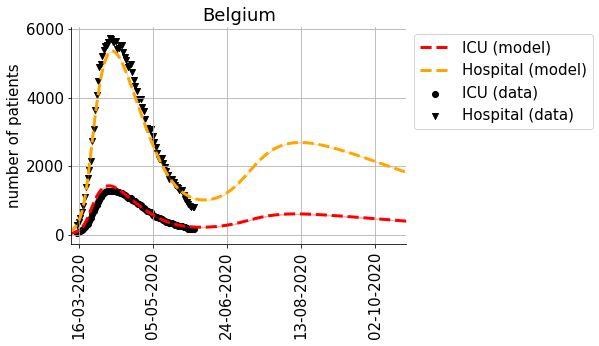

In [ ]:
positions=[np.array([6]),np.array([5,6])]
# Run realTimeScenario
model.realTimeScenario(startdate,data,positions,pastPolicy,futurePolicy=futurePolicy,trace={'beta': [model.beta]},T_extra=124,
                       modelClr=['red','orange'],legendText=('ICU (model)','Hospital (model)','ICU (data)','Hospital (data)'),
                       titleText='Belgium',filename='test.svg')

Save your figures by altering the variable `filename = xxxxx.svg`!